# Time Series Basic Autoregression
This code demonstrates basic autoregression.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

First, lets load a time series data from Yahoo Finances using Pandas datareader 

In [2]:
stck = pd.read_csv('out.csv') #stck = web.DataReader('HMC', data_source = 'yahoo', start = '2/1/2018', end = '2/1/2019')
#stck.set_index('Date')
stck.index = pd.to_datetime(stck['Date'])
stck.head()



,Date,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,,
2017-02-01,2017-02-01,30.230000,29.889999,30.230000,29.959999,981700,29.959999
2017-02-02,2017-02-02,30.250000,30.059999,30.200001,30.219999,1092800,30.219999
2017-02-03,2017-02-03,31.100000,30.709999,30.920000,31.059999,1040800,31.059999
2017-02-06,2017-02-06,30.980000,30.680000,30.950001,30.870001,993300,30.870001
2017-02-07,2017-02-07,31.540001,31.309999,31.490000,31.379999,1508400,31.379999


The average of daily high and low is interpreted as the daily value.

In [3]:
stck_av = pd.DataFrame(data=.5*(stck['High']+stck['Low']), columns=['HMC'])

stck_av.head()

,HMC
Date,
2017-02-01,30.059999
2017-02-02,30.155000
2017-02-03,30.905000
2017-02-06,30.830000
2017-02-07,31.425000


Two time series are constructed to contain annual average and standard deviation of daily values:

In [4]:
fr_ave = stck_av.groupby(pd.Grouper(freq='A')).mean().dropna()
fr_std = stck_av.groupby(pd.Grouper(freq='A')).std().dropna()
fr_ave = pd.DataFrame(data = fr_ave).reset_index()
fr_std = pd.DataFrame(data = fr_std).reset_index()
fr_ave.head()

,Date,HMC
0,2017-12-31,29.875693
1,2018-12-31,31.382032
2,2019-12-31,26.926210
3,2020-12-31,27.464047


These series are resampled to match the index of the daily values series. Then the series is normalized using the average and the STD series:

In [5]:

fr_ave = (fr_ave.set_index('Date')
                .resample('D')
                .ffill()
        )
fr_std = (fr_std.set_index('Date')
                .resample('D')
                .ffill() 
         )

stck_norm = pd.DataFrame(data=(stck_av['HMC'] - fr_ave['HMC']) / fr_std['HMC'], columns=['HMC']).dropna()
stck_norm.head()

,HMC
Date,
2018-01-02,2.124424
2018-01-03,2.293056
2018-01-04,2.611047
2018-01-05,2.717043
2018-01-08,2.801360


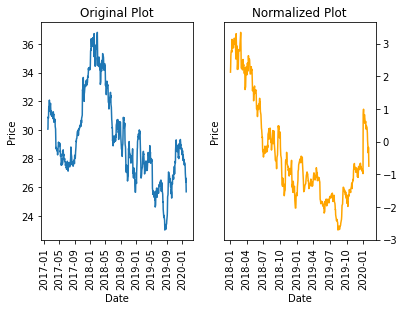

In [6]:

fig, axs = plt.subplots(1,2)
axs[0].plot('HMC', data = stck_av)
axs[0].set_title('Original Plot')
axs[1].plot('HMC',data = stck_norm,color='orange')
axs[1].set_title('Normalized Plot')

axs[1].yaxis.tick_right()
for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Price')
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

In [7]:
from sklearn.linear_model import LinearRegression

Three series are constructed by shifting the normalized values 30, 60 and 90 days. These series are then used for autoregression.

In [8]:
X1 = stck_norm.shift(periods=30).reset_index().drop(range(0,90))
X2 = stck_norm.shift(periods=60).reset_index().drop(range(0,90))
X3 = stck_norm.shift(periods=90).reset_index().drop(range(0,90))

pasts = pd.DataFrame(data=X1['HMC']).rename(columns={'HMC': 'M1'})
pasts['M2'] = X2['HMC']
pasts['M3'] = X3['HMC'] 
pasts.head()

,M1,M2,M3
90,2.285829,2.285828,2.124424
91,2.042517,2.635137,2.293056
92,2.136469,2.815814,2.611047
93,2.167787,2.784497,2.717043
94,2.403871,2.786905,2.801360


In [9]:
y = stck_norm['HMC'].reset_index().drop(range(0,90)).drop(columns=['Date'])

In [10]:
model = LinearRegression().fit(pasts, y)
m = model.coef_[0]
b = model.intercept_
z = m[0]*pasts['M1'] + m[1]*pasts['M2'] + m[2]*pasts['M3'] + b
z.head()

90    1.021683
91    0.856001
92    0.896873
93    0.907387
94    1.057855
dtype: float64

The overall trend in the normalized data and the regressed series are compared:

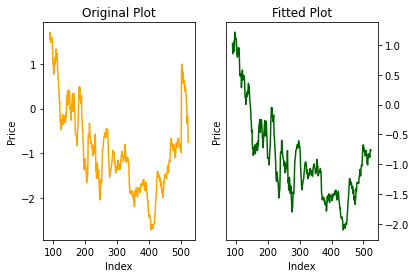

In [11]:
fig, axs = plt.subplots(1,2)
axs[0].plot('HMC',data = y ,color='orange')
axs[0].set_title('Original Plot')
axs[1].plot(z ,color='darkgreen')
axs[1].set_title('Fitted Plot')
axs[1].yaxis.tick_right()

for ax in axs.flat:
    ax.set(xlabel='Index', ylabel='Price')

The $R^2$ statistic is calculated to asses the accuracy of the model

In [12]:
import sklearn
r_squared = sklearn.metrics.r2_score(y['HMC'],z,multioutput='uniform_average')
r_squared

0.5856159617912202